In [1]:
import os, scipy
import os.path as osp
from balloon import balloonWindkessel
import nibabel as nib
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from signal_processing import *

In [2]:
def show_slices(slices):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")

In [3]:
func_dir = 'data/sub-08/func/'

In [4]:
# Getting fmri timeseries vector
img = nib.load(osp.join(func_dir, 'swarsub-08_task-flanker_run-1_bold.nii'))
img_data = img.get_fdata()

## Hemodynamic Response curve

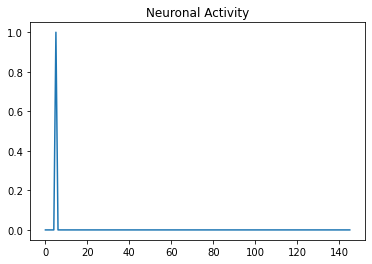

In [5]:
# z = np.array([norm(40, 4).pdf(i) for i in range(146)])
z = np.zeros(146)
x = 1
z[5] = x
plt.title('Neuronal Activity')
plt.plot(z)
plt.show()

In [14]:
x0 = [1, 0.32, 0.65, 0.41, 0.98, 0.34, 0.02]
bold, _, _, _, _ = balloonWindkessel(*x0[1:], z, 0.5, 0, False)
bold = bold[0]

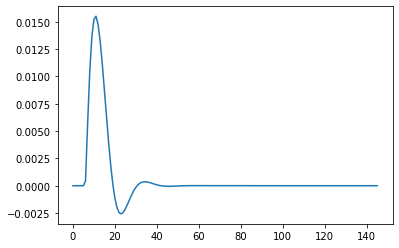

In [15]:
plt.plot(bold)
# plt.legend()
# plt.ylim(-0.005, 0.005)
plt.show()

In [16]:
con= np.loadtxt(osp.join(func_dir, 'congruent_run1.txt')).T[0]/2
inc = np.loadtxt(osp.join(func_dir, 'incongruent_run1.txt')).T[0]/2                       

In [17]:
z = np.zeros(146)
for i in con: 
    z[int(i)-1] = 0.5
for i in inc:
    z[int(i)-1] = 1

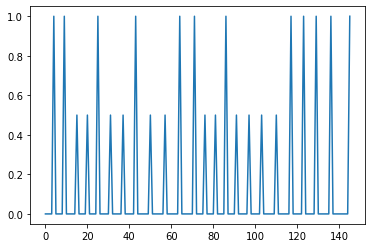

In [13]:
plt.plot(z)

In [18]:
x0 = [1, 0.32, 0.65, 0.41, 0.98, 0.34, 0.02]
bold, _, _, _, _ = balloonWindkessel(*x0[1:], z, 0.5, 0, False)
bold = bold[0]

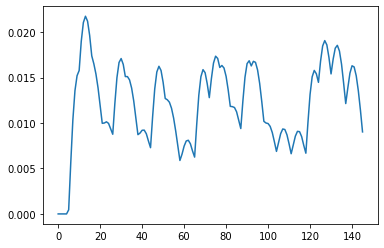

In [19]:
plt.plot(bold)

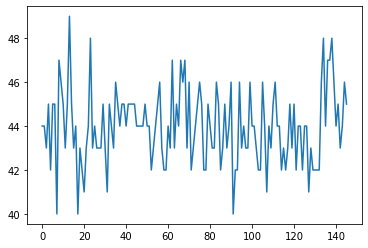

In [20]:
slice_0 = img_data[15, 13, 13, :]
plt.plot(slice_0)

## Signal denoising

#### Detrending
This removes a linear trend over the time series of each voxel. This is a useful step when studying fMRI data, as the voxel intensity itself has no meaning and we want to study its variation and correlation with other voxels.

In [21]:
dslice_0 = signal.detrend(slice_0)
dbold = signal.detrend(bold)

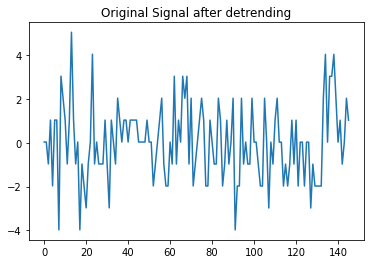

In [22]:
plt.title('Original Signal after detrending')
plt.plot(dslice_0)
plt.show()

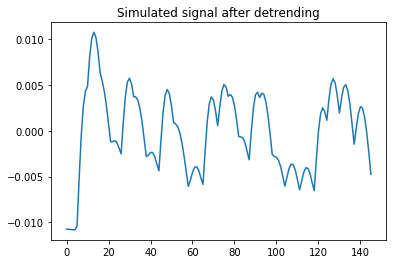

In [23]:
plt.title('Simulated signal after detrending')
plt.plot(dbold)
plt.show()

#### Filtering 
BOLD signal is mixed with various non-neuronal/physiological signal. BOLD generally lies in 0.01-0.25 Hz range. Other frequencies can be filtered

In [27]:
b, a = signal.butter(5, [0.01, 0.25], btype = 'bandpass')

In [28]:
fdslice_0 = signal.lfilter(b, a, dslice_0)

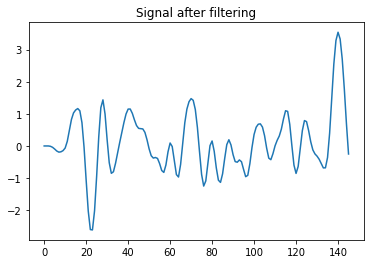

In [29]:
plt.plot(fdslice_0)
plt.title('Signal after filtering')
plt.show()

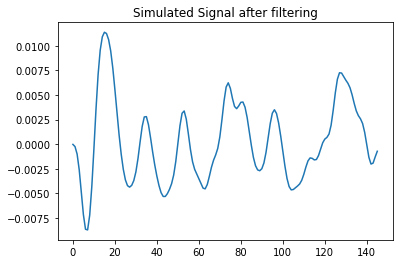

In [30]:
fdbold = signal.lfilter(b, a, dbold)
plt.plot(fdbold)
plt.title('Simulated Signal after filtering')
plt.show()

#### Normalization
Consists in setting the timeseries variance to 1

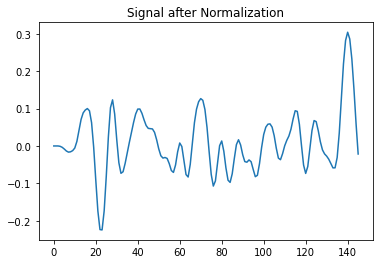

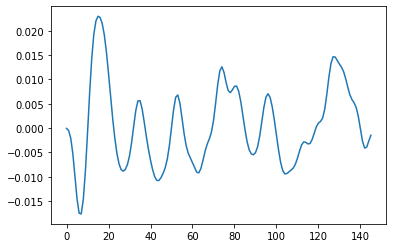

In [37]:
std = np.sqrt((fdslice_0 ** 2).sum(axis=0))
if std < np.finfo(float).eps: std = 1.  # avoid numerical problems
fdslice_0 /= std
plt.plot(fdslice_0)
plt.title('Signal after Normalization')
plt.show()
plt.plot(fdbold/np.sqrt(fdbold**2).sum(axis=0))
# pritnnormalization(fdbold)

In [36]:
x0 = [1, 0.32, 0.65, 0.41, 0.98, 0.34, 0.02]
to_opt = lambda x, z, sampling_rate:  np.mean((fdslice_0 - x[0] * balloonWindkessel(*x[1:], z, sampling_rate, 1, False)[0][0])**2)
opt = minimize(to_opt, x0, (z, 0.5), method = 'Nelder-Mead', bounds = [(1, 3), (0.01, 0.5), (0.01, 1), (0.01, 1), (0.01, 1), (0.01, 1), (0.001, 1)])
# opt = minimize(to_opt, x0, (z, 0.5), method = 'Nelder-Mead')

/tmp/ipykernel_3787/2424077967.py:2: RuntimeWarning: overflow encountered in square
  to_opt = lambda x, z, sampling_rate:  np.mean((fdslice_0 - x[0] * balloonWindkessel(*x[1:], z, sampling_rate, 1, False)[0][0])**2)
/mnt/d/Stuff/MS/Brain_Modelling/balloon/balloon.py:45: RuntimeWarning: overflow encountered in power
  E = lambda x: 1.0 - (1.0 - rho)**(1.0/x) # x is f, in this case


In [169]:
opt////

 final_simplex: (array([[1.05016369, 0.41726141, 0.03109026, 0.62868339, 0.68722746,
        0.48190337, 0.01684755],
       [1.05016928, 0.41728653, 0.03109211, 0.62867489, 0.68715637,
        0.48191184, 0.01684498],
       [1.05016224, 0.41728937, 0.03109211, 0.62867476, 0.68715713,
        0.48189534, 0.01684759],
       [1.05015408, 0.41722496, 0.03109148, 0.62867776, 0.68730781,
        0.48192039, 0.01684977],
       [1.05016715, 0.4172858 , 0.03109109, 0.62867946, 0.68717594,
        0.48189368, 0.01684676],
       [1.05017138, 0.41727468, 0.03109246, 0.62867316, 0.68719407,
        0.48191769, 0.01684463],
       [1.05015349, 0.41722216, 0.03109295, 0.62867111, 0.68730155,
        0.48193561, 0.01684898],
       [1.05015954, 0.41725627, 0.03109237, 0.62867378, 0.68722905,
        0.48191623, 0.01684784]]), array([0.00638657, 0.00638657, 0.00638657, 0.00638657, 0.00638657,
       0.00638657, 0.00638657, 0.00638657]))
           fun: 0.006386573036136052
       message: 'Optimiz

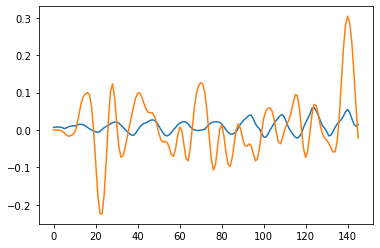

In [39]:
plt.plot(opt.x[0] * balloonWindkessel(*opt.x[1:], z, 0.5, 1, False)[0][0])
plt.plot(fdslice_0)